## Load pretrained model

In [1]:
import re
import transformers
from transformers import DonutProcessor, VisionEncoderDecoderModel

import torch
import matplotlib.pyplot as plt

# hidde logs
transformers.logging.disable_default_handler()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("Mo-oN/donut-base-DO")
model = VisionEncoderDecoderModel.from_pretrained("/data/moon/donut-base-DO/checkpoint-4800/").to(device)

/home/moon/miniconda3/envs/donut/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load delivery order test dataset

In [48]:
from dataset import DeliveryOrder
filepath = "./"
dataset = DeliveryOrder(filepath, split='test')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## Dataset preprocessing

In [49]:
processed_dataset = dataset.preprocess_documents_for_donut()
print(len(processed_dataset))

15


## Inference on test sample

In [50]:
def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        output_attentions=True,
    )
    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target, outputs

In [280]:
test_sample = processed_dataset[1]
prediction, target, outputs = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")

/tmp/ipykernel_546845/2043591347.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)


Reference:
 {'SHIPPER': 'MK TRADING LLC', 'CARRIER': 'HYUNDAI MERCHANT MARINE (AMERICA) INC', 'VESSEL': 'HYUNDAI MARS 037W', 'POL': 'LONG BEACH,CA', 'POD': 'BUSAN, KOREA', 'ETD': '02/01/2023', 'ETA': '02/17/2023', 'COMMODITY': ''}
Prediction:
 {'SHIPPER': 'MK TRADING LLC', 'CARRIER': 'HYUNDAI MERCHANT MARINE (AMERICA) INC', 'VESSEL': 'HYUNDAI MARS 037W', 'POL': 'LONG BEACH,CA', 'POD': 'BUSAN, KOREA', 'ETD': '02/01/2023', 'ETA': '02/17/2023', 'COMMODITY': ''}


## Visualize cross-attention results

In [281]:
dec_txt = {}
for i, t in enumerate(outputs.sequences[0]):
    dec_txt[i] = processor.decode(t)

In [282]:
print(dec_txt)

{0: '<s>', 1: '<s>', 2: '<s_SHIPPER>', 3: 'MK', 4: 'TRA', 5: 'D', 6: 'ING', 7: 'LLC', 8: '</s_SHIPPER>', 9: '<s_CARRIER>', 10: 'HY', 11: 'UND', 12: 'AI', 13: '', 14: 'MER', 15: 'CH', 16: 'ANT', 17: 'MAR', 18: 'INE', 19: '(', 20: 'A', 21: 'MER', 22: 'ICA', 23: ')', 24: 'INC', 25: '</s_CARRIER>', 26: '<s_VESSEL>', 27: 'HY', 28: 'UND', 29: 'AI', 30: 'MAR', 31: 'S', 32: '03', 33: '7', 34: 'W', 35: '</s_VESSEL>', 36: '<s_POL>', 37: '', 38: 'LONG', 39: 'BE', 40: 'ACH', 41: ',', 42: 'CA', 43: '</s_POL>', 44: '<s_POD>', 45: 'BU', 46: 'SAN', 47: ',', 48: 'KO', 49: 'REA', 50: '</s_POD>', 51: '<s_ETD>', 52: '02', 53: '/', 54: '01', 55: '/20', 56: '23', 57: '</s_ETD>', 58: '<s_ETA>', 59: '02', 60: '/17', 61: '/20', 62: '23', 63: '</s_ETA>', 64: '<s_COMMODITY>', 65: '</s_COMMODITY>', 66: '</s>'}


In [283]:
indices = [2,3,4,5,6] # SHIPPER

In [286]:
import cv2
from vis_utils import *
from copy import deepcopy

def vis(img_path, tkn_indices, decoder_cross_attentions, final_w=1920, final_h=2560):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (final_w, final_h))
    
    max_area_box, thres_heatmap, agg_heatmap = attn_heatmap(tkn_indices, decoder_cross_attentions)
    raw_heatmap = deepcopy(agg_heatmap)
    raw_image = deepcopy(image)

    # x1, y1, x2, y2 = box
    x1, y1, x2, y2 = max_area_box
    cv2.rectangle(image, (x1, y1), (x2, y2), (255,100,200), 2)

    heatmap_img = cv2.applyColorMap(thres_heatmap, cv2.COLORMAP_JET)
    super_imposed_img = cv2.addWeighted(heatmap_img, 0.2, image, 0.8, 0)
    # super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, image, 0.5, 0)

    super_imposed_raw_heatmap_img = cv2.addWeighted(cv2.applyColorMap(raw_heatmap, cv2.COLORMAP_JET), 0.2, raw_image, 0.8, 0)
    # super_imposed_raw_heatmap_img = cv2.addWeighted(cv2.applyColorMap(raw_heatmap, cv2.COLORMAP_JET), 0.5, raw_image, 0.5, 0)

    # display image with heatmap
    images_2_disp = [super_imposed_raw_heatmap_img, super_imposed_img]
    plt.figure(figsize=(12, 18))
    # plt.figure(figsize=(30, 30))
    columns = 2
    for i, img2disp in enumerate(images_2_disp):
        plt.subplot(len(images_2_disp) // columns + 1, columns, i + 1)
        plt.imshow(img2disp)    

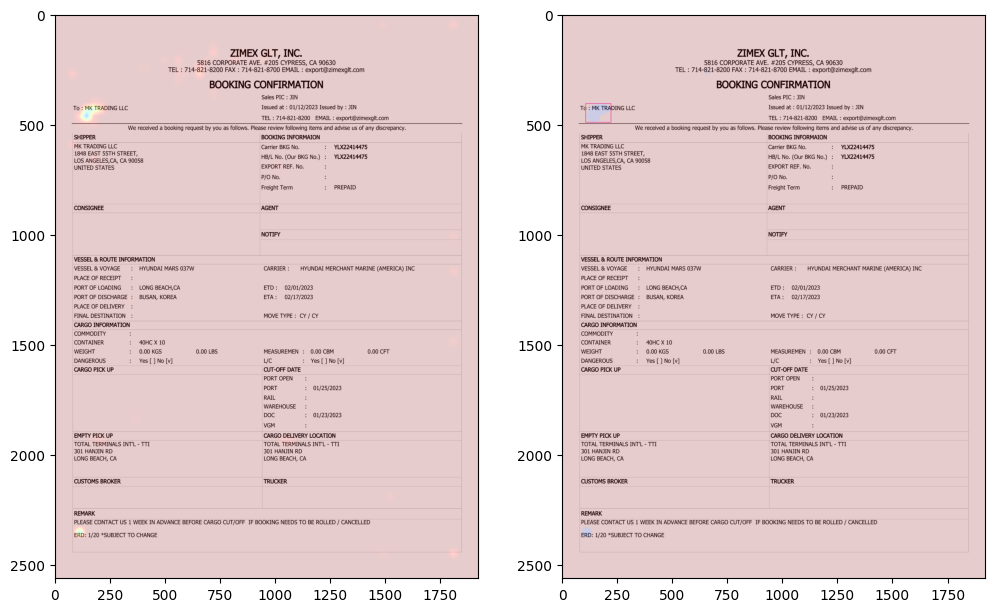

In [287]:
img_path = "./test/PE_112.png"
vis(img_path, indices, outputs.cross_attentions)